In [1]:
# from pathlib import Path

# repository_path = Path('..').resolve()

# !pip install -Uqq {repository_path}
# %pip install -e ..
    


# !export PYTHONPATH=$PYTHONPATH:{repository_path}
# !echo $PYTHONPATH

<a target="_blank" href="https://colab.research.google.com/github/Luan-vP/glider/blob/main/notebooks/walkthrough.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [2]:
import glider.visualize as visualize
import glider.vehicle as vehicle

import mediapy as media

# GliderSIM

This is a genetic algorithm to optimise a glider form.

That means we put a population of gliders through a test and see which perform the best. The best candidates have offspring, which make up the next generation.

The best gliders of that generation have offspring and so on, until we have a set of gliders that are performing pretty well on our test.


## The Gliders

Gliders are a combination of points and faces that make up a polygon. They look like this:

""

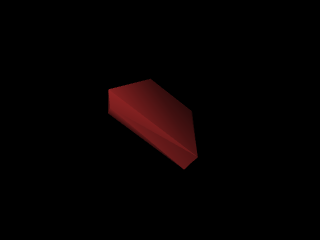

In [3]:
v = vehicle.Vehicle(
    num_vertices=10,
    max_dim_m=5,
    )
media.show_image(visualize.view_vehicle(*v.create_glider_from_vertices()))

## The Test

The test is a drop from 80m.

The glider's score is determined by the distance travelled to the left or right before it touches the landing platform.

The simulation uses the open source Physics simulator Mujoco, developed by DeepMind. A test for the glider above, looks like this:

In [4]:
import glider.simulation as simulation

test_xml_representation = simulation.drop_test_glider(
    *v.create_glider_from_vertices()
)

visualize.render_xml_to_collision(
    test_xml_representation,
    camera_name="fixed",
    show=True
)

We can get a numerical score for the gliders "fitness", by measuring the x-position at the time of collision. 

The wrapping `fitness_func` function includes the simulation steps and returns only numerical value we're interested in.

In [5]:
import glider.optimization as optimization

score = optimization.fitness_func(v)

print(f"Glider Score: {score}")

Glider Score: 22.39425408919721


## Improving the glider shape

The first, and simplest way to get a better glider, is to try a variety of shapes. 

In the cell below, we create a population of gliders, and test each one according to our fitness function.

In [6]:
population = [vehicle.Vehicle(num_vertices=10, max_dim_m=5) for _ in range(100)]

fitnesses = [optimization.fitness_func(v) for v in population]

We can now select the best gliders according to the test, and see what they look like:

""

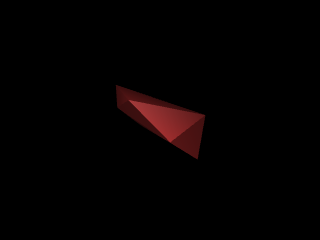

Fitness: 18.666517510317902


""

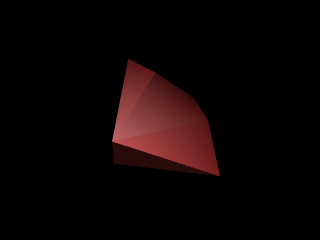

Fitness: 15.911809547967687


""

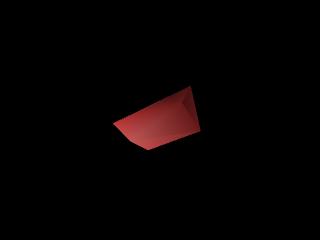

Fitness: 15.901808399198451


In [7]:
ranking = list(zip(population, fitnesses))
ranking.sort(key=lambda x: x[1], reverse=True)  # Sort by highest to lowest fitness

for glider, fitness in ranking[:3]:
    media.show_image(visualize.view_vehicle(*glider.create_glider_from_vertices()))
    print(f"Fitness: {fitness}")

Graphing the distribution of the glider performances, we get:

<Axes: ylabel='Frequency'>

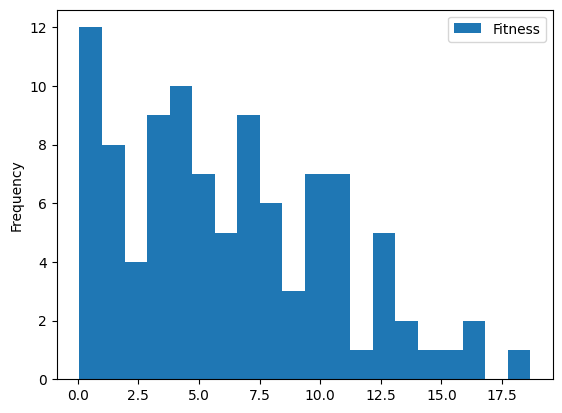

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(ranking, columns=["Vehicle", "Fitness"])
df.plot.hist(bins=20)

The drop test for the best glider, looked like this:

In [9]:
winning_glider, fitness = ranking[0]

drop_test_xml = simulation.drop_test_glider(*winning_glider.create_glider_from_vertices())

visualize.render_xml_to_collision(
    drop_test_xml,
    camera_name="fixed",
    show=True
)

These will be similar to the parents, but not the same, allowing us to whittle into adjacent niches.

In [16]:
from io import BytesIO

from glider.optimization import iterate_population, fitness_func
from glider.visualize import view_vehicle

best_glider_frames = []
population_performance_frames = []

max_wing_dimension_m = 4.5

new_population = [vehicle.Vehicle(num_vertices=10, max_dim_m=max_wing_dimension_m) for _ in range(100)] 
for i in range(300):
    ranking, new_population = iterate_population(
        population=new_population,
        max_dim_m=max_wing_dimension_m,
        survival_weight = 0.4,
        cloning_weight = 0.4,
    )

    if i % 10 == 0:
        print("Iteration:", i)
        winning_vehicle = population[0]
        print("Fitness:", fitness_func(winning_vehicle))

    best_glider_frames.append(view_vehicle(*winning_vehicle.create_glider_from_vertices()))
    
    df = pd.DataFrame(ranking, columns=["Vehicle", "Fitness"])
    fig = df.plot.hist(bins=20).get_figure()
    fig_io = BytesIO()
    population_performance_frames.append(fig.savefig(fig_io, format='png'))
    population_performance_frames.append(fig_io.getvalue())
    plt.close(fig)


    


Iteration: 0
Fitness: 10.557743517686362
Iteration: 10
Fitness: 10.557743517686362
Iteration: 20
Fitness: 10.557743517686362
Iteration: 30
Fitness: 10.557743517686362
Iteration: 40
Fitness: 10.557743517686362
Iteration: 50
Fitness: 10.557743517686362
Iteration: 60
Fitness: 10.557743517686362
Iteration: 70
Fitness: 10.557743517686362
Iteration: 80
Fitness: 10.557743517686362
Iteration: 90
Fitness: 10.557743517686362
Iteration: 100
Fitness: 10.557743517686362
Iteration: 110
Fitness: 10.557743517686362
Iteration: 120
Fitness: 10.557743517686362
Iteration: 130
Fitness: 10.557743517686362
Iteration: 140
Fitness: 10.557743517686362
Iteration: 150
Fitness: 10.557743517686362
Iteration: 160
Fitness: 10.557743517686362
Iteration: 170
Fitness: 10.557743517686362
Iteration: 180
Fitness: 10.557743517686362
Iteration: 190
Fitness: 10.557743517686362
Iteration: 200
Fitness: 10.557743517686362
Iteration: 210
Fitness: 10.557743517686362
Iteration: 220
Fitness: 10.557743517686362
Iteration: 230
Fitness

In [ ]:
media.show_video(best_glider_frames, fps=3)

In [ ]:
v = vehicle.Vehicle(vertices=population[0])
v.show()

TypeError: 'Vehicle' object is not iterable

In [ ]:
import glider.simulation as sim

glider_xml, glider_asset = v.create_glider_from_vertices()
world_xml = sim.drop_test_glider(glider_xml, glider_asset)

from pathlib import Path

p = Path('../assets/worlds/drop_test.xml').resolve()
p.parent.mkdir(parents=True, exist_ok=True)

with open('../assets/worlds/drop_test.xml', 'w') as f:
    f.write(world_xml)